# <font  color = "#0093AF">$T_1$ limits</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter2/Ch2_T1_limits.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

Longitudinal relaxation occurs because a relative fast motion—on the timescale of the lab frame rotation—induces a slow evolution of the density matrix. In this notebook, we check the validity of this lab frame calculation against analytical formulas, and also investigate the range in which equilibrium of the system to thermal equilibrium (via `'DynamicThermal'`) is valid.

## SETUP

In [0]:
# SETUP SLEEPY
!pip install sleepy-nmr

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
# !git clone https://github.com/alsinmr/pyDR     #Uncomment on Google Colab to import pyDR.
#pyDR will also install MDAnalysis on Colab
import pyDR

## Range of $T_1$ validity

### Build the system

We mimick a tumbling motion by hopping around the 'rep10' power average. Note that tumbling is currently only implemented for colinear tensors without asymmetry (we don't include a gamma average, so this yields vector tumbling, not tensor tumbling).

In [3]:
# Since we use a tumbling model, we only need a single angle in the powder average
ex0=sl.ExpSys(v0H=400,Nucs=['15N','1H'],vr=0,LF=True,pwdavg='alpha0beta0')
ex0.set_inter('dipole',i0=0,i1=1,delta=22954.8)

# Set up tumbling
q=2
ex,kex=sl.Tools.SetupTumbling(ex0,q=q,tc=1e-9)  #This hops around the rep10 powder average

L=sl.Liouvillian(*ex,kex=kex)
seq=L.Sequence(Dt=.1)

We plot the full Liouvillian below, just to give an idea what the exchange looks like.

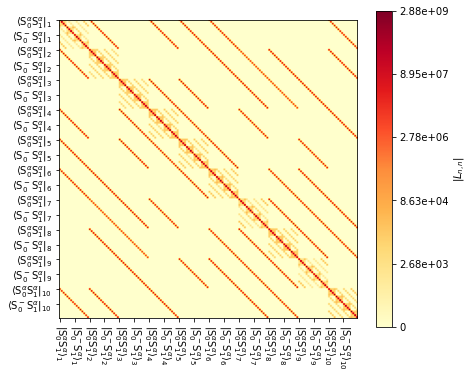

In [4]:
ax=L.plot()
ax.figure.set_size_inches([6,6])

### Sweep the correlation time
We don't use explicit propagation. Instead, we extract the decay rates using `rho.extract_decay_rates` to find the $T_1$ decay. We also calculate the signal at equilibrium. This is done by raising the density matrix to an infinite power (internally, we don't really use infinity- this just triggers an algorithm to calculate the equilibrium density matrix)

In [5]:
tc0=np.logspace(-5,-13,80)
rho=sl.Rho('15Nz','15Nz')
R1=[]
for tc in tc0:
    rho.clear()
    L.kex=sl.Tools.SetupTumbling(ex0,q=q,tc=tc)[1]
    R1.append(rho.extract_decay_rates(seq))

### Plot the results

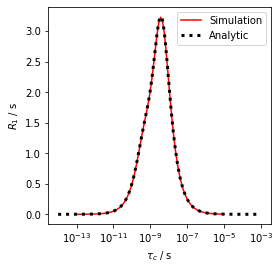

In [6]:
ax=plt.subplots(1,1,figsize=[4,4])[1]
ax.semilogx(tc0,R1,color='red')
nmr=pyDR.Sens.NMR(v0=400,Nuc='15N',CSA=0,Type='R1')
ax.semilogx(nmr.tc,nmr.rhoz.T,color='black',linestyle=':',linewidth=3)
ax.set_xlabel(r'$\tau_c$ / s')
ax.set_ylabel(r'$R_1$ / s')
_=ax.legend(('Simulation','Analytic'))

We see extremely good agreement between the simulation and the analytical formulas implemented in [pyDR](https://alsinmr.github.io/pyDR).

## Dynamic Thermal performance
The method `L.add_relax('DynamicThermal)` gives us the ability to add recovery to thermal equilibrium to systems where longitudinal relaxation is introduced by an exchange process (necessarily in the lab frame). This is not a fully accurate approach, as it does not properly introduce non-adiabatic contributions to the coherences. A good discussion is found in Bengs and Levitt.$^1$. We do not expect this particular limitation to present problems in the applications presented here. We will not be able to introduce electron effects like the contact and pseudocontact shift via exchange-induced relaxation of the electrons: we'll have to use explicitly defined relaxation of the electron instead. To the best of our knowledge, no approach exists to induce contact shift via exchange-induced electron relaxation.

A second limitation occurs, which is numerical stability of the approach. Essentially, when fast dynamics ($\tau_c<10^{-10}$) is present, numerical error between the fast dynamics and slow recovery fails to stably reach equilibrium. We demonstrate below, where we evaluate the relaxation rate constants and thermal equilibrium.

[1] C. Bengs, M.H. Levitt. [*J. Magn. Reson*](https://doi.org/10.1016/j.jmr.2019.106645), **2020**, 310, 106645.

### Thermalize the system

In [7]:
_=L.add_relax('DynamicThermal')

### Sweep the correlation time

We just have to add the recovery mechanism (above), and repeat the calculation. Note we initialize at thermal equilibrium, and invert the $^{15}$N magnetization at the beginning, to be able to observe decay. This is because the function `rho.extract_decay_rates` always assumes decay towards zero. Therefore, we can't start at zero, and we can't start at thermal equilibrium. This also means that the decay is twice as fast as if it were going towards zero, thus we divide by two.

In [8]:
tc0=np.logspace(-5,-13,80)
rho=sl.Rho('Thermal',['15Nz','1Hz'])
R1=[]
Ieq=[]
for tc in tc0:
    rho.clear()
    L.kex=sl.Tools.SetupTumbling(ex0,q=q,tc=tc)[1]
    U=seq.U()
    L.Udelta('15N')*rho
    R1.append(rho.extract_decay_rates(U)/2)  #Divide by 2
    L.Udelta('15N')*rho
    Ieq.append((U**np.inf*rho)().I[:,0].real)

### Plot the results

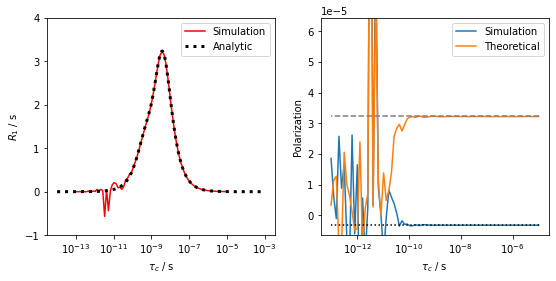

In [9]:
ax=plt.subplots(1,2,figsize=[9,4])[1]
ax[0].semilogx(tc0,R1,color='red')
nmr=pyDR.Sens.NMR(v0=400,Nuc='15N',CSA=0,Type='R1')
ax[0].semilogx(nmr.tc,nmr.rhoz.T,color='black',linestyle=':',linewidth=3)
ax[1].semilogx(tc0,np.array(Ieq))
ax[1].semilogx([tc0[0],tc0[-1]],ex0.Peq[0]*np.ones(2),linestyle=':',color='black')
ax[1].semilogx([tc0[0],tc0[-1]],ex0.Peq[1]*np.ones(2),linestyle='--',color='grey')
ax[1].set_ylim([ex0.Peq[0]*2,ex0.Peq[1]*2])

for a in ax:a.set_xlabel(r'$\tau_c$ / s')
ax[0].set_ylabel(r'$R_1$ / s')
ax[0].legend(('Simulation','Analytic'))
ax[0].set_ylim([-1,4])
ax[1].set_ylabel('Polarization')

_=ax[1].legend(('Simulation','Theoretical'))

Below, we plot a simulation below and above the failure threshold.

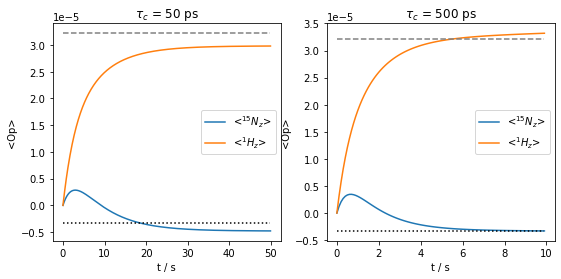

In [10]:
ax=plt.subplots(1,2,figsize=[9,4])[1]

tc=5e-11
rho=sl.Rho('zero',['15Nz','1Hz'])
L.kex=sl.Tools.SetupTumbling(ex0,q=q,tc=5e-11)[1]
rho.DetProp(L.Sequence(Dt=0.1),n=500)
rho.plot(axis='s',ax=ax[0])
ax[0].plot(rho.t_axis[[0,-1]],ex0.Peq[0]*np.ones(2),color='black',linestyle=':')
ax[0].plot(rho.t_axis[[0,-1]],ex0.Peq[1]*np.ones(2),color='grey',linestyle='--')
ax[0].set_title(fr'$\tau_c$ = {tc*1e12:.0f} ps')

tc=5e-10
rho=sl.Rho('zero',['15Nz','1Hz'])
L.kex=sl.Tools.SetupTumbling(ex0,q=q,tc=5e-10)[1]
rho.DetProp(L.Sequence(Dt=0.1),n=100)
rho.plot(axis='s',ax=ax[1])
ax[1].plot(rho.t_axis[[0,-1]],ex0.Peq[0]*np.ones(2),color='black',linestyle=':')
ax[1].plot(rho.t_axis[[0,-1]],ex0.Peq[1]*np.ones(2),color='grey',linestyle='--')
_=ax[1].set_title(fr'$\tau_c$ = {tc*1e12:.0f} ps')

We see that for the shorter correlation time, thermal equilibrium is not achieved (dashed/dotted lines indicate the thermal equilibrium for the two spins).

## Better "DynamicThermal" performance for smaller systems
The validity of `'DynamicThermal'` is better for smaller exchange systems, due to less numerical error buildup. Here, we consider a system in two-site exchange. We need to include a powder average to compare to the analytical formulas (since these are valid only for orientationally averaged relaxation). We also need to include a scaling factor, $1-S^2$, for the relaxation, where $S^2$ can be calculated from the angle of the two-site hop:

$$
\begin{equation}
S^2=\frac14+\frac34\cos^2\phi
\end{equation}
$$

In [11]:
phi=np.pi/4
S2=1/4+3/4*np.cos(phi)**2

ex0=sl.ExpSys(v0H=400,Nucs=['15N','1H'],vr=0,LF=True,pwdavg=2)
delta=sl.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=22954.8)
ex1=ex0.copy().set_inter('dipole',i0=0,i1=1,delta=22954.8,euler=[0,phi,0])

L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(1e-8))
L.add_relax('DynamicThermal')

seq=L.Sequence(Dt=.1)

In [12]:
tc0=np.logspace(-5,-13,80)
rho=sl.Rho('Thermal',['15Nz','1Hz'])
R1=[]
Ieq=[]
for tc in tc0:
    rho.clear()
    L.kex=sl.Tools.twoSite_kex(tc=tc)
    U=seq.U()
    L.Udelta('15N')*rho
    R1.append(rho.extract_decay_rates(U)/2)  #Divide by 2
    L.Udelta('15N')*rho
    Ieq.append((U**np.inf*rho)().I[:,0].real)

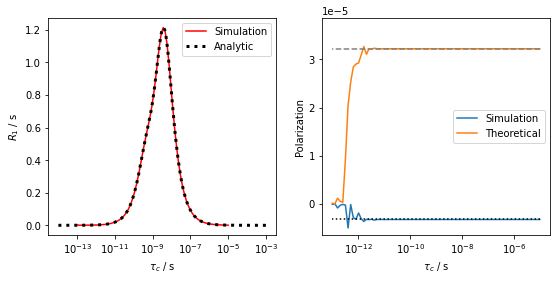

In [13]:
ax=plt.subplots(1,2,figsize=[9,4])[1]
ax[0].semilogx(tc0,R1,color='red')
nmr=pyDR.Sens.NMR(v0=400,Nuc='15N',CSA=0,Type='R1')
ax[0].semilogx(nmr.tc,nmr.rhoz.T*(1-S2),color='black',linestyle=':',linewidth=3)
ax[1].semilogx(tc0,np.array(Ieq))
ax[1].semilogx([tc0[0],tc0[-1]],ex0.Peq[0]*np.ones(2),linestyle=':',color='black')
ax[1].semilogx([tc0[0],tc0[-1]],ex0.Peq[1]*np.ones(2),linestyle='--',color='grey')
ax[1].set_ylim([ex0.Peq[0]*2,ex0.Peq[1]*1.2])

for a in ax:a.set_xlabel(r'$\tau_c$ / s')
ax[0].set_ylabel(r'$R_1$ / s')
ax[0].legend(('Simulation','Analytic'))
ax[1].set_ylabel('Polarization')

_=ax[1].legend(('Simulation','Theoretical'))

We see that the correct thermal equilibrium is maintained at correlation times almost two orders of magnitude shorter.